# RA Diagnosis Extraction with Machine Learning

In [51]:
PATH_MODULES = '../../../../modules/'
SEED = 26062019

test_size = 0.5 

import sys
sys.path.append(PATH_MODULES)
import buildingAClassifier as bc
from pattern import __version__ as pat_vers
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, model_selection, tree, preprocessing, metrics
import sklearn.ensemble as ske
from matplotlib import __version__ as m_vers
from sklearn import __version__ as sk_vers
import re
import random
import pickle

# %matplotlib inline

# ske= 0.21.2

print('Current versions Modules:\n')
print('Pandas version:\t\t' + pd.__version__)
print('Matplotlib version:\t' + m_vers)
print('numpy version:\t\t' + np.__version__)
print('sklearn version:\t' + sk_vers)
print('pattern version:\t' + pat_vers)

Current versions Modules:

Pandas version:		0.22.0
Matplotlib version:	2.1.2
numpy version:		1.15.1
sklearn version:	0.19.1
pattern version:	3.6


In [3]:
def binarize(value):
    if value == 'j':
        return 'y'
    elif value == 'n':
        return 'n'
    elif value == 'p':
        return 'n'

radiag_df = pd.read_csv(r'data/annotation_v2_20190125.csv', index_col=0, sep="|", na_values=['NA'])
radiag_df['Outcome'] = radiag_df['Outcome'].apply(lambda x : binarize(x)) 
lemma_radiag_df = radiag_df.copy()
print('Nr of entries:', len(radiag_df))
#radiag_df.head()

Nr of entries: 1361


## Step 1: Cleaning Data

### 1.1 Preprocessing - Word segmentation and lemmatizing 

In [4]:
radiag_df['XANTWOORD'] = radiag_df['XANTWOORD'].apply(lambda x : bc.simpleCleaning(x, lemma=True))

### 1.2 Balancing classes in data (50% RA cases and 50% non cases)
The number of non-cases is larger than nr. of cases so a random sample of non cases is selected to create a balance between the classes. 

In [5]:
df_no_outcome = radiag_df[radiag_df['Outcome']=='n'].sample(len(radiag_df[radiag_df['Outcome']=='y']), random_state=SEED)
equal_radiag_df = pd.concat([df_no_outcome, radiag_df[radiag_df['Outcome']=='y']])
equal_radiag_df = equal_radiag_df.sample(frac=1, random_state=SEED)

### 1.3 Splitting annotated set on both the textual data and the label (Y)

In [6]:
X = equal_radiag_df['XANTWOORD'].values
y = equal_radiag_df[['ID', 'Outcome']].values
y_tot = equal_radiag_df['Outcome'].values

### 1.4 Visualizing the data
#### Plot: Prevalence of RA-cases
Positive control -> classes should be in balance

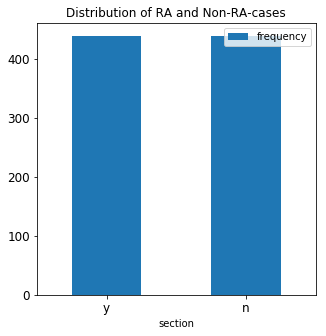

In [8]:
from collections import Counter

labels, values = zip(*Counter(equal_radiag_df['Outcome']).items())

df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="Distribution of RA and Non-RA-cases", figsize=(5, 5), x='section', legend=True, fontsize=12, rot=0)

#### Plot: Lexical Dispersion Plot
- Showcases the prevalence of features
- The feature’s homogeneity across the entries

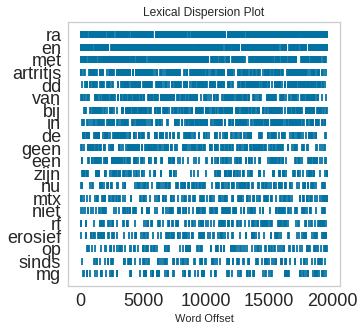

In [7]:
from yellowbrick.text import DispersionPlot

nr_features = 20

# Create a dictionary with all words
count = 0
words = []
for x in X:
    words.append([i for i in x.split(' ')])
    count+=1
word_list = np.array(words)

# Assess most prevalent features
words_to_count = [word.split(' ') for word in X]
words_to_count = [item for entry in words_to_count for item in entry] # flatten
counts = Counter(words_to_count)
feature_to_plot = [ counts.most_common(nr_features)[x][0] for x in range(nr_features) ]

# Create the visualizer and draw the plot
visualizer = DispersionPlot(feature_to_plot, size=(350, 350))
ax = visualizer.ax
ax.tick_params(labelsize=18)
visualizer.fit(word_list)
visualizer.poof()

#### Plot: Feature distribution

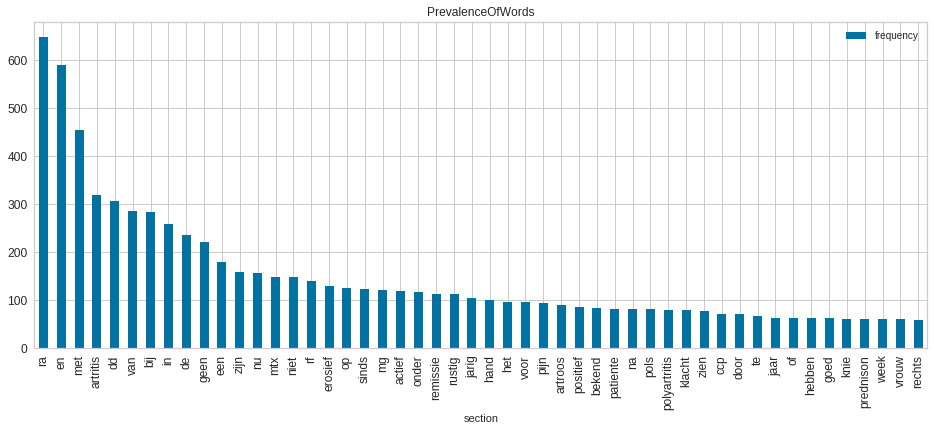

In [8]:
from collections import Counter
nr_features = 50


labels =[ counts.most_common(nr_features)[x][0] for x in range(nr_features) ]
values= [ counts.most_common(nr_features)[x][1] for x in range(nr_features) ]
#print(values)

df = pd.DataFrame({'section':labels, 'frequency':values})
ax = df.plot(kind='bar',  title ="PrevalenceOfWords", figsize=(16, 6), x='section', legend=True, fontsize=12, rot=90)
plt.savefig('figures/feature_plot/top50_features_dist.png', bbox_inches='tight')

## Step 2: Building the Pipeline

First: Import important modules

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.dummy import DummyClassifier


### 2.1 Import different classification models:
Listed below are the following models: Naive Bayes, Gradient Boosting, Neural Networks, Decision tree & SVM.

In [11]:
pipe_list = [
    # Naive Bayes - 0
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB()),
            ]),
    # Gradient Boosting - 1
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', ske.GradientBoostingClassifier(random_state=SEED))
            ]),
    # Neural Networks - 2
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MLPClassifier(solver='lbfgs', random_state=SEED)), # hidden_layer_sizes=(5, 2), , 
            ]),
    # Decision Tree - 3
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', tree.DecisionTreeClassifier(random_state=SEED)),
            ]),
    # SVM 4 - NuSVC probability
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', NuSVC(probability=True,random_state=SEED)),
            ]),
    # Random Forest 5 
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=SEED)), # n_estimators=100, max_depth=2,
            ]),
    # Dummy 6
    Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DummyClassifier(random_state=SEED)),
            ])
    ]


### 2.2 Initialize the Word Matching Method
The word matching method classifies based on the presence of the provided targets.

The following targets are provided: 'rheumatoid arthritis', 'reumatoide artritis' and 'ra'. 

In [12]:
import buildingAClassifier as bC

l_targets = ['rheumatoid arthritis', 'reumatoide artritis', 'ra']
WordMatching = bC.CustomBinaryModel(l_targets)

## Step 3: Compare classification models
Visualize performance of the models in ROC curve

Word Matching 0.7539219616229005 (std : +/-0.01958155283532 )
Decision Tree 0.8344517497403452 (std : +/-0.02073529809788606 )
Train-score Decision Tree 0.994949494949495 (std : +/-4.965068306494546e-17 )
Naive Bayes 0.863115949992258 (std : +/-0.013514723158018032 )
Train-score Naive Bayes 0.982411197655972 (std : +/-0.0020936403834738828 )
Gradient Boosting 0.935486398774177 (std : +/-0.007673328149513902 )
Train-score Gradient Boosting 0.994949494949495 (std : +/-3.510833468576701e-17 )
Neural Networks 0.9057124685760768 (std : +/-0.012321867451605545 )
Train-score Neural Networks 0.994949494949495 (std : +/-0.0 )
SVM 0.9001892407634179 (std : +/-0.010712761907465248 )
Train-score SVM 0.9937945415222488 (std : +/-0.0018386034198001574 )
Random Forest 0.8860982709754429 (std : +/-0.010801975365410972 )
Train-score Random Forest 0.994894578013009 (std : +/-0.0001030051595844052 )
Dummy 0.49177325611087247 (std : +/-0.012880743028026694 )
Train-score Dummy 0.49271255731750646 (std : +/

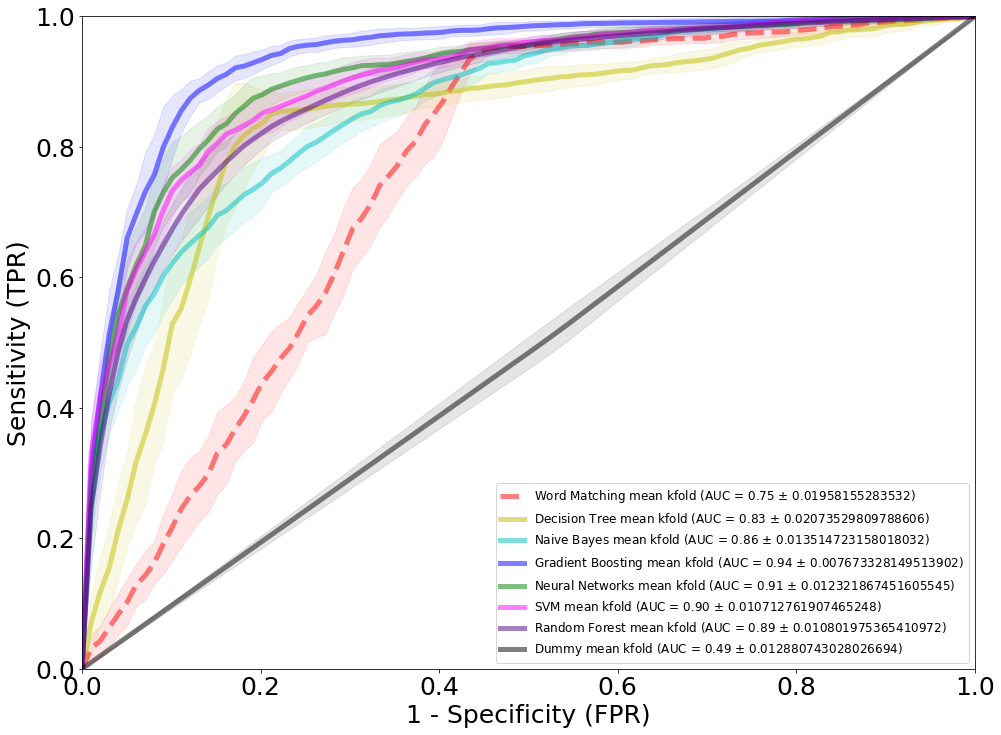

In [14]:
import matplotlib.pyplot as plt

lbls = ['Naive Bayes', 'Gradient Boosting', 'Neural Networks', 'SVM', 'Random Forest', 'Dummy']

l_folds = bC.preset_CV10Folds(X)
filtered_pipe = pipe_list[:3] + pipe_list[4:7] # exclude decision -> because it cant assess the probabilities!
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(16,12))

plt, ref_auc, auc_ref, fitted_wm = bC.plotCustomModelROC(WordMatching, X, y_tot, l_folds, 'Word Matching', 'r', '--') # custom made roc
plt, dt_auc, auc_dt, fitted_dt = bC.plotBinaryROC(pipe_list[3], 'Decision Tree', X, y_tot, l_folds, 'y')
plt, d_aucs, fitted_models = bC.plotCrossValidationROC(filtered_pipe,'ROC curve for different classification methods', lbls, X, y_tot, l_folds, ref_auc)
plt.savefig('figures/ROC_curve_all_methods.png', bbox_inches='tight')

### 3.1. Student's T-Test relative to Naive Word Matching

In [15]:
import scipy

for key in d_aucs.keys(): # classifiers with probas
    twosample_results = scipy.stats.ttest_ind(d_aucs[key], auc_ref)
    print(key, '\t(p =', str(twosample_results[1]), ')')

print('Decision Tree\t(p =', scipy.stats.ttest_ind(auc_dt, auc_ref)[1], ')')

Naive Bayes 	(p = 4.952012056716027e-11 )
Gradient Boosting 	(p = 1.0493039482219844e-15 )
Neural Networks 	(p = 1.1793526410135888e-13 )
SVM 	(p = 1.1535697334183527e-13 )
Random Forest 	(p = 7.137698159469661e-13 )
Dummy 	(p = 1.1143560900157703e-17 )
Decision Tree	(p = 1.0537843963980759e-07 )


## Step 4: Distribute Model - save best classification model

In [16]:
best_model = fitted_models['Gradient Boosting'][2] # median iteration
filename='savedModels/GradientBoostingModel.sav'
pickle.dump(best_model, open(filename, 'wb'))

### 4.1 Import best performing model

In [17]:
filename='savedModels/GradientBoostingModel.sav'
loaded_model = pickle.load(open(filename, 'rb'))

## Step 5: Evaluate best Model
Determine cut-off

In [19]:
gbm_model = fitted_models['Gradient Boosting']

# Import the fitted model + fold information + the optimal cut_off
estimator = gbm_model[2]
test_index = gbm_model[3]
train_index = gbm_model[4]
cut_off = gbm_model[5]

# Create the exact same folds
X_test_fold = X[test_index]
X_train_fold = X[train_index]
y_test_fold = np.array([bC.binarize(val) for val in y_tot])[test_index]
y_train_fold = np.array([bC.binarize(val) for val in y_tot])[train_index]

# Apply the cut-off on the probabilities -> to assess the predictions
l_pred = [int(gbm_model[0][i] >= cut_off) for i in range(len(gbm_model[0]))]

### 5.1 Evaluate Performance on lower prevalence of RA-cases

GBM 50/50 0.9352746587213285 (std : +/-0.007185033516277609 )
GBM .20 0.9270832444809337 (std : +/-0.021380389979267528 )
GBM .05 0.9253480977213906 (std : +/-0.04193075642082462 )


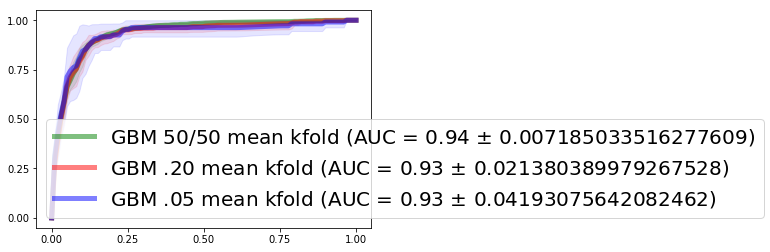

In [20]:
from scipy import interp


plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 10})
plt, mean_auc = bC.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array([bC.binarize(val) for val in y_tot]), 1, 'GBM 50/50', 'g')
plt, mean_auc = bC.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array([bC.binarize(val) for val in y_tot]), .2, 'GBM .20', 'r')
plt, mean_auc = bC.classifyOnLowerPrevalence(filtered_pipe[1], X, np.array([bC.binarize(val) for val in y_tot]), .05, 'GBM .05', 'b')
plt.savefig('figures/results/ROC_GBM_LowPrevalenceRA.png', bbox_inches='tight')

### 5.2 Visualize optimal cut-off

       1-fpr       fpr        tf  thresholds       tpr
60  0.883621  0.116379  0.000437    0.651049  0.884058


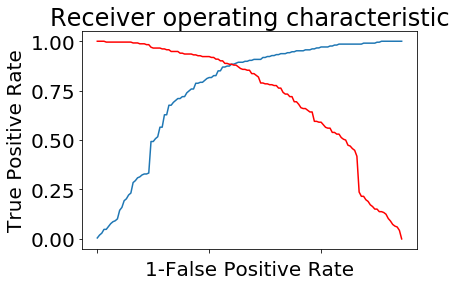

In [21]:
cut_off = bC.optimalCutoff(gbm_model[0], y_test_fold, 'Gradient Boosting', True)

### 5.3 Confusion Matrix 
Visualize proportions of true positives, true negatives, false positives and false negatives

Confusion matrix, without normalization
[[205  27]
 [ 24 183]]


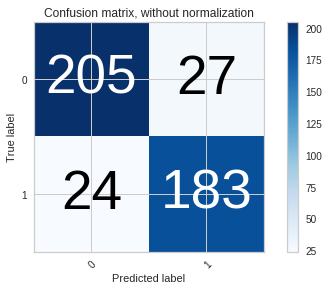

In [32]:
bC.plot_confusion_matrix(y_test_fold, l_pred, classes=['0', '1'],
                      title='Confusion matrix, without normalization')
plt.savefig('figures/results/GBM_confusion_matrix.png', bbox_inches='tight')
plt.show()

### 5.4 Calculate performance characteristics

In [22]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test_fold, l_pred).ravel()
sensitivity,specificity = tp/(tp+fn),tn/(tn+fp)
accuracy = (tp + tn)/(tp+fn+tn+fp)
ppv,npv = tp/(tp+fp),tn/(tn+fn)
print('Sensitivity: ' + str(sensitivity), '\nSpecificity: ' + str(specificity))
print('PPV: ' +str(ppv), '\nNPV: ' + str(npv))
print('Accuracy: ' +str(accuracy))

Sensitivity: 0.8840579710144928 
Specificity: 0.8836206896551724
PPV: 0.8714285714285714 
NPV: 0.8951965065502183
Accuracy: 0.8838268792710706


### 5.5 Investigate the incorrect predictions
Optional: Which cases where wrongly predicted

In [17]:
predictions = estimator.predict(X_test_fold)
for inp, prediction, label in zip(X_test_fold, predictions, y_test_fold):
    #print(inp, prediction, label)
    if prediction != label:
        print('"', inp, '"\n\n', 'has been classified as ', prediction, 'and should be ', label, '\n') 
print('Cannot print example of output')

Cannot print example of output


## Step 6: Inner workings of the black box 
Optional Visualizations -> of best model & median Fold
### 6.1 Pearson correlation per feature

Bbox(x0=-0.2673004956252613, y0=0.09999999999999998, x1=0.4459589635003584, y1=19.900000000000002)


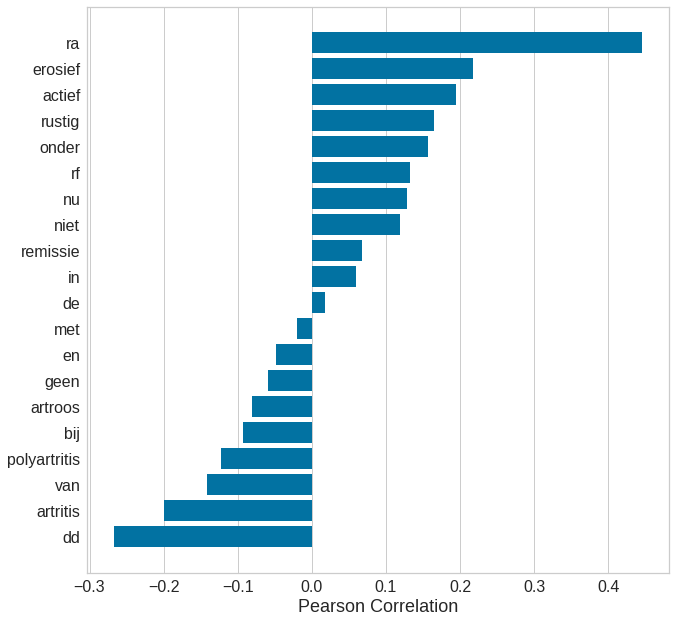

In [47]:
from sklearn import datasets
from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import StandardScaler
import seaborn as sns

count_vect = CountVectorizer() # ngram_range=(2, 2)
X_train_counts = count_vect.fit_transform(X_train_fold) # learning the vocabulary dictionary
tfidf_transformer = TfidfTransformer() ## remove common words
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

plt.figure(figsize=(8,6))
# Load the regression data set
Xs, ys = X_train_tfidf, y_train_fold

feature_names = np.array(count_vect.get_feature_names())
X_pd = pd.DataFrame(X_train_tfidf.toarray(), columns=count_vect.get_feature_names())

# Transform
trans = StandardScaler()
trans.fit(X_pd)
def binarize(value):
    return int(value == 'y')
Y_pd = pd.DataFrame(y_tot[train_index])[0].apply(lambda x : binarize(x))
X_pd2 = pd.DataFrame(trans.transform(X_pd), columns=count_vect.get_feature_names())

feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:20]) #['ra', 'dd', 'reumatoide', 'artritis', 'patient', 'de', 'het', 'spa', 'methotrexaat', 'prednison']
#feature_to_plot.append('psoriatica')

visualizer = FeatureCorrelation(labels=feature_to_plot, size=(750, 750), sort=True)

visualizer.fit(X_pd2[feature_to_plot], Y_pd)
ax = visualizer.ax
ax.set_xlabel('Pearson Correlation', fontsize=18)
ax.tick_params(labelsize=16)

visualizer.finalize()
plt.rcParams.update({'font.size': 55})
plt.title('', fontsize=20, fontweight='bold')
#ax.set_yticklabels(labels=['ra', 'active', 'erosive', 'on', 'not-active', 'mtx', 'rf', 'remission', 'not', 'currently', 'the', 'and', 'with', 'mg', 'in', 'no', 'of/from', 'in case of/by', 'arthritis', 'dd'][::-1])

print(ax.dataLim)

plt.show()


# of the top 20 features with the highest corrected term frequency

### 6.2 Explained variance per feature
The importance of each feature reflects the model error caused by exclusion of said feature

Andere range? -> komt dit door andere functie? 

ra                   34.596477
rustig               21.267369
en                   20.483113
met                  18.888867
artritis             17.840297
dd                   17.165883
in                   16.117573
actief               15.534772
remissie             14.785182
bij                  14.780837
rf                   14.371136
van                  13.303252
nu                   12.496350
erosief              11.648289
geen                 11.411353
de                   11.184200
polyartritis         11.085790
niet                 10.980798
onder                10.827779
artroos               9.346554
mtx                   9.262832
mg                    9.151368
bekend                8.333736
sinds                 8.167642
een                   7.741917
ccp                   7.660909
positief              7.489241
op                    7.153387
psoriatica            6.775897
hand                  6.401482
                       ...    
kaagewricht           0.077884
nadruk  

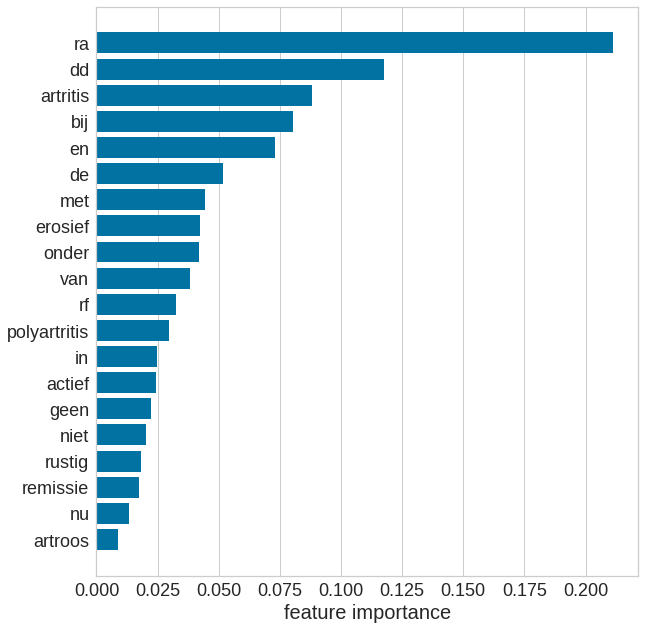

In [48]:
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier

from yellowbrick.features.importances import FeatureImportances

# Create a new matplotlib figure

feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:20]) 
viz = FeatureImportances(GradientBoostingClassifier(), size=(750, 750), relative=False)
print(X_pd.sum().sort_values().sort_values(ascending=False))
#feature_to_plot.append('reumatoide')
#feature_to_plot.append('psoriatica')
#feature_to_plot.append('pmr')

viz.fit(X_pd[feature_to_plot], y_tot[train_index])

 # Print values 
ax = viz.ax
ax.tick_params(labelsize=18)
#ax.set_yticklabels(labels=['ra', 'dd', 'arthritis', 'erosive', 'in case of/by', 'and', 'on', 'of/from', 'the', 'remission', 'polyarthritis', 'with', 'active', 'in', 'not', 'rf', 'no', 'not-active', 'currently', 'artrose'][::-1])
ax.set_xlabel('Feature Importance', fontsize=20)

viz.finalize()

plt.title('', fontsize=28, fontweight='bold')
# Feature Importances of top 20 features using Gradient Boosting

plt.show()


### 6.3 Trainingset | Lexical Dispersion Plot 

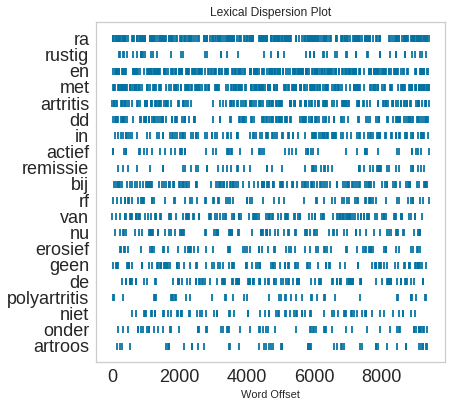

In [25]:
from yellowbrick.text import DispersionPlot
count = 0
d = {}
a = np.array([])
words = []
for x in X_train_fold:
    words.append([i for i in x.split(' ')])
    count+=1
    
d = np.array(words)

feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:20]) 

# Create the visualizer and draw the plot
visualizer = DispersionPlot(feature_to_plot, size=(450, 450))
ax = visualizer.ax
ax.tick_params(labelsize=18)
visualizer.fit(d)
visualizer.poof()

### 6.4 Testset | Lexical Dispersion Plot 

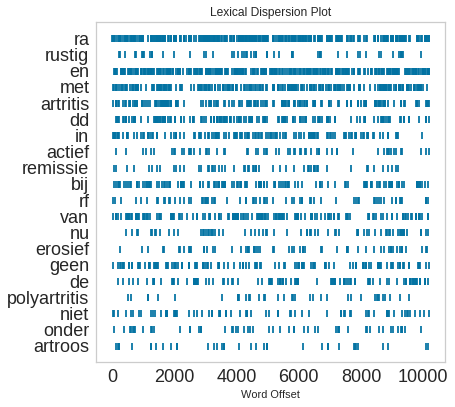

In [26]:
from yellowbrick.text import DispersionPlot
count = 0
d = {}
a = np.array([])
words = []
for x in X_test_fold:
    words.append([i for i in x.split(' ')])
    count+=1
    
d = np.array(words)

feature_to_plot =list(X_pd.sum().sort_values(ascending=False).keys()[:20]) 

# Create the visualizer and draw the plot
visualizer = DispersionPlot(feature_to_plot, size=(450, 450))
ax = visualizer.ax
ax.tick_params(labelsize=18)
visualizer.fit(d)
visualizer.poof() 

### 6.5 Plot distribution of n=50 prevalent features
Should be comparable -> otherwise you dont have a representable train/test set

##### Input:
- nr_features = number of features to draw in the distribution plot

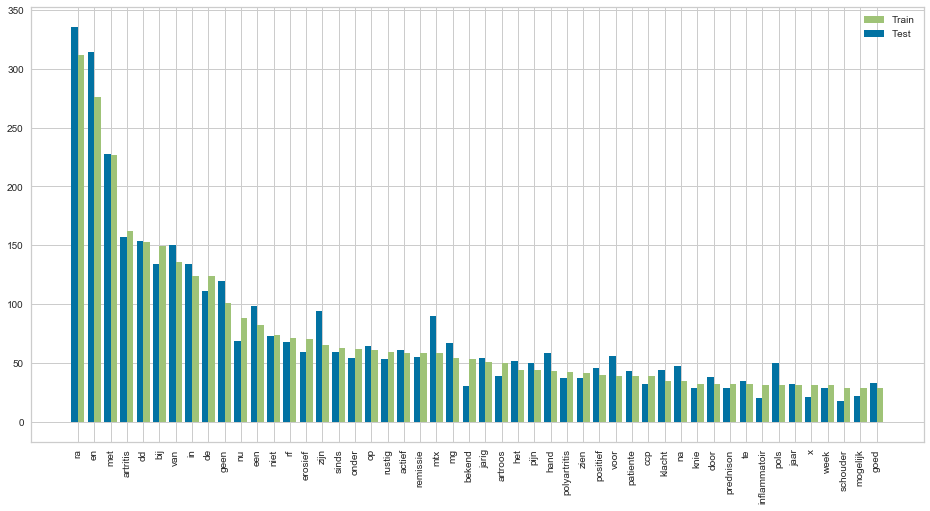

In [118]:
from collections import Counter
import matplotlib.pyplot as plt
nr_features = 50


# Assess most prevalent features
words_to_count = [word.split(' ') for word in X_train_fold]
words_to_count = [item for entry in words_to_count for item in entry] # flatten
counts_train = Counter(words_to_count) 

train_labels =[ counts_train.most_common(nr_features)[x][0] for x in range(nr_features) ]
train_values= [ counts_train.most_common(nr_features)[x][1] for x in range(nr_features) ]

test_labels = train_labels # use same labels
test_values = []

words_to_count_test = [word.split(' ') for word in X_test_fold]
words_to_count_test = [item for entry in words_to_count_test for item in entry] # flatten
counts_test = Counter(words_to_count_test) 

for x in train_labels:
    test_values.append(counts_test.get(x))

fig, ax = plt.subplots(figsize=(16,8))

p1 = ax.bar([x + 0.2 for x in range(nr_features)], train_values, width=0.4, color='g', align='center')
p2 = ax.bar([x - 0.2 for x in range(nr_features)], test_values, width=0.4, color='b', align='center')
p3 = ax.bar(train_labels, [x - 0.2 for x in range(nr_features)], alpha=0, width=0.4, color='b', align='center')
ax.legend((p1[0], p2[0]), ('Train', 'Test'))

plt.xticks(rotation='vertical')
plt.show()